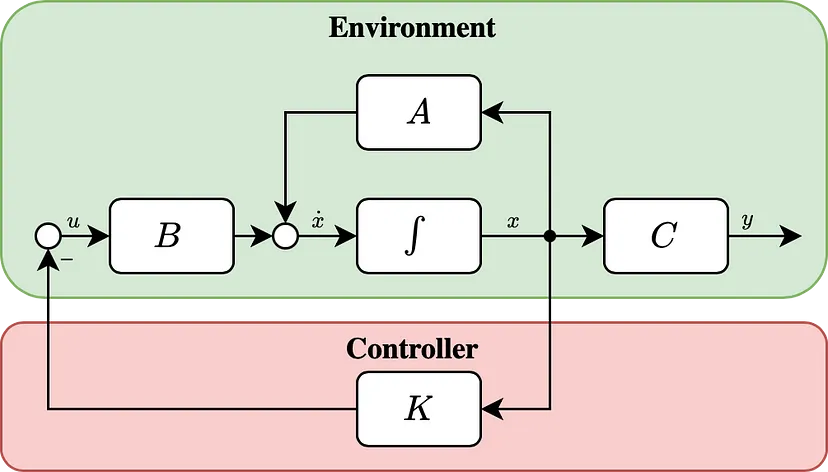

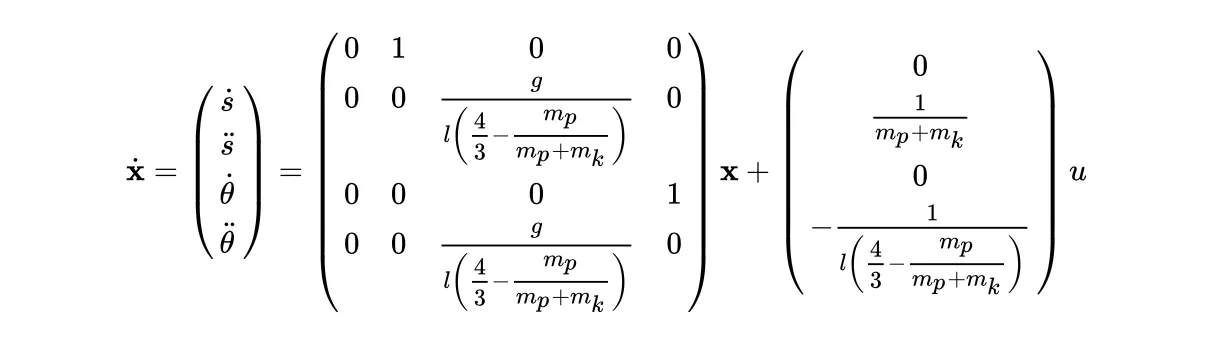

In [1]:
import numpy as np
from cartpole import CartPoleEnv
from scipy import linalg

In [2]:
# get environment
env = CartPoleEnv(render_mode='human')
env.reset(options={'low': -0.5, 'high': 0.5})
env.theta_threshold_radians = 180 * 2 * np.pi / 360

# print environment parameters
for key in env.__dict__:
    print(key + ':', env.__dict__[key])

# state matrix
a = env.gravity / (env.length * (4.0 / 3 - env.polemass_length / (env.total_mass)))
A = np.array([[0, 1, 0, 0], [0, 0, a, 0], [0, 0, 0, 1], [0, 0, a, 0]])

# input matrix
b = -1 / (env.length * (4.0 / 3 - env.polemass_length / (env.total_mass)))
B = np.array([[0], [1 / env.total_mass], [0], [b]])

gravity: 9.8
masscart: 1.0
masspole: 0.1
total_mass: 1.1
length: 0.5
polemass_length: 0.05
force_mag: 10.0
tau: 0.02
kinematics_integrator: euler
theta_threshold_radians: 3.141592653589793
x_threshold: 2.4
action_space: Discrete(2)
observation_space: Box([-4.8000002e+00 -3.4028235e+38 -4.1887903e-01 -3.4028235e+38], [4.8000002e+00 3.4028235e+38 4.1887903e-01 3.4028235e+38], (4,), float32)
render_mode: human
screen_width: 600
screen_height: 400
screen: <Surface(600x400x32 SW)>
clock: <Clock(fps=0.00)>
isopen: True
state: [ 0.04654665  0.28116954 -0.38893737  0.45497271]
steps_beyond_terminated: None
_np_random: Generator(PCG64)
surf: <Surface(600x400x32 SW)>


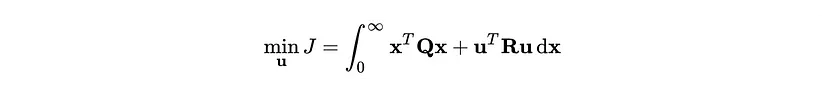

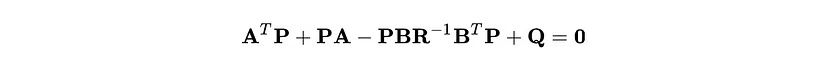

In [3]:
R = 5 * np.eye(1, dtype=int)  # choose R (weight for input)
Q = 5 * np.array(
    [[5, 0, 0, 0], [0, 2, 0, 0], [0, 0, 10, 0], [0, 0, 0, 5]]
)  # choose Q (weight for state)

# solve ricatti equation
P = linalg.solve_continuous_are(A, B, Q, R)

# calculate optimal controller gain
K = np.dot(np.linalg.inv(R), np.dot(B.T, P))
print(K)

[[ -2.23606798  -2.95793131 -46.21390255  -9.70135589]]


In [4]:
def apply_state_controller(K, x):
    # feedback controller
    u = -np.dot(K, x)  # u = -Kx
    if u > 0:
        return 1, u  # if force_dem > 0 -> move cart right

    return 0, u  # if force_dem <= 0 -> move cart left

In [5]:
obs = env.state

for i in range(1000):
    env.render()

    # get force direction (action) and force value (force)
    action, force = apply_state_controller(K, obs)

    # absolute value, since 'action' determines the sign, F_min = -10N, F_max = 10N
    abs_force = abs(float(np.clip(force, -10, 10)))

    # change magnitute of the applied force in CartPole
    env.force_mag = abs_force

    # apply action
    obs, reward, terminated, truncated, info = env.step(action)
    if terminated:
        print(f'Terminated after {i+1} iterations.')
        break

env.close()

KeyboardInterrupt: 

In [8]:
import pygame
from gym.utils.play import play

mapping = {(pygame.K_LEFT,): 0, (pygame.K_RIGHT,): 1}
play(CartPoleEnv(render_mode='rgb_array'), keys_to_action=mapping)